# Martinez Assignment 8 - Ensemble Methods



This assignment is a bit different. One of the key expectations from any published article is reproducibility of results, especially in data science. In the last assignment in this course, you are tasked with attempting to reproduce the study described in a peer-reviewed article, published by the National Institute of Health (nih.gov). This tasked is aimed at gradually building your capacity to tackle complex topics, familiarize yourself with academic discourse, and provide context and practice for the skills you will eventually need when working on your capstone thesis or project.

Ensemble-Based Classifier

Familiarize yourself with the ensemble package in Python and its use in a Jupyter notebook by utilizing the “Ensemble Methods for Classification of Physical Activities” to complete this assignment. 

Note the additional digital resources in Supplemental Digital Content at the bottom of the article. Also, note that the dataset used in the article is available for download from the UCI repository and the direct link is included in the article in the Methods section, Data set 1.

Another useful resource is “A Comprehensive Guide to Ensemble Learning (with Python codes).”

Once you have reviewed the required resources, complete the following:

Follow the steps described in the article for acquiring the data and building a classifier (in Python) that implements an ensemble framework. It is expected that you will encounter obstacles along the way and not every step mentioned in the article will be straightforward to implement. Ideally, you will be able to reproduce the project in its entirety. Less than ideal, but still very useful, would be to attempt most steps, adapt some, maybe eliminate one or two classification methods from the ensemble, but still produce a working classifier. Given the breadth and depth of the projects you worked on in this course and given the detailed resources provided that cover both theory and implementation, you are expected to successfully complete this project.

In the event that you are able to fully implement the steps described in the article, it would make an excellent opportunity to write a paper informing the scientific community (and the authors) that you are corroborating the results. If you followed the steps to the letter, it would be even more interesting if you obtained a different result. In such case, the scientific community should hear from you.

Create a technical report (no need to rewrite the article), in which you document your work, all steps, including the code and its output. Compare the results to the ones in the article, even if your ensemble framework is not identical to the one described in the article.

APA style is expected, as well as formal and rigorous scientific writing, using appropriate mathematical notation and references.

This assignment uses a rubric. Review the rubric prior to beginning the assignment to become familiar with the expectations for successful completion.

You are not required to submit this assignment to LopesWrite.

Benchmark Information:
This benchmark assignment assesses the following programmatic competency: 

MS Data Science


1.2 Effectively use variety of data analytics techniques, such as Machine Learning (including supervised, unsupervised, semisupervised learning), Data Mining, Prescriptive and Predictive Analytics, for complex data analysis through the whole data lifecycle.


In [134]:
import pandas as pd
import numpy as np
import os # for the file merging
from sklearn.impute import SimpleImputer # To handle the null values
from matplotlib import pyplot as plt
from sklearn.ensemble import VotingClassifier # Weighted Voting ('soft')
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.svm import SVC # Support vector machine
from sklearn.neural_network import MLPClassifier # ANN
from sklearn.tree import DecisionTreeClassifier # Binary decision tree
from sklearn.naive_bayes import MultinomialNB # For the Behavior Knowledge Space
from sklearn.naive_bayes import GaussianNB # Naive Bayes
import itertools

In [31]:
# There are nine files, one per subject. So all will be combined in order to simplify the process.

path = '../data/PAMAP2_Dataset/Protocol'

file_list = os.listdir(path)
for filename in sorted(file_list):
    out_filename = 'pamap.txt'
    with open(out_filename, 'a') as outfile:
        with open(path + '/' + filename, 'r') as infile:
            outfile.write(infile.read())

In [140]:
# Load the combined subject dataset into a dataframe
# The study only used the wrist data, so the rest is dropped

cols = ['timestamp', 'activityID', 'heartrate', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6'
        ,'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17']

df = pd.read_csv('pamap.txt', ' ', header=None)

df.drop(df.iloc[:, 20:], axis = 1, inplace=True)
df.columns=cols

In [141]:
df.shape

(2872533, 20)

In [5]:
# Convert the dataframe to time series. Because we only have seconds, the dates will start at the 
# unix epoch start date of 1970-01-01. 

# df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

In [6]:
df['activityID'].value_counts()

0     929661
4     238761
17    238690
1     192523
3     189931
7     188107
2     185188
16    175353
6     164600
12    117216
13    104944
5      98199
24     49360
Name: activityID, dtype: int64

In [142]:
# Per the dataset instructions, an activityID of 0 should be removed
# The study did not explicitly state whether or not they removed it,
# but it would be prudent to do so.
# Only the data from the accelerometer is used so heartrate will also be dropped.
# In addition, only values w2-4 are for the +/- 16g accelerometer
# Which is the one used in the study. The other columns will be dropped.

df.drop(df[df['activityID'] == 0].index, inplace=True)
#df.drop('heartrate', inplace=True, axis=1)

keeps = ['timestamp', 'activityID', 'w2', 'w3', 'w4']
df = df[keeps]

df.columns

Index(['timestamp', 'activityID', 'w2', 'w3', 'w4'], dtype='object')

In [143]:
# So we have quite a few null values that will have to be handled.
# There are a consistent number of nulls that comprise only 0.5% of the entire dataset
# The easiest thing would be to drop them, but in the spirit of the study, they will
# be imputed.

# The authors used linear interpolation to determine the values, but for simplicity,
# mean will be used here.
df[df['w2'].isnull()]

,timestamp,activityID,w2,w3,w4
19193,200.31,1,NaN,NaN,NaN
19194,200.32,1,NaN,NaN,NaN
19195,200.33,1,NaN,NaN,NaN
34152,349.90,2,NaN,NaN,NaN
45999,468.37,2,NaN,NaN,NaN
...,...,...,...,...,...
2843922,3884.86,24,NaN,NaN,NaN
2843923,3884.87,24,NaN,NaN,NaN
2843950,3885.14,24,NaN,NaN,NaN
2871906,93.97,24,NaN,NaN,NaN


In [144]:
# The authors used linear interpolation to determine the values, but for simplicity,
# mean will be used here.
# Use the simpleimputer class from sklearn and leverage 'mean' as the fill value
fill_NaN = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_df = pd.DataFrame(fill_NaN.fit_transform(df))

# Rebuild the dataframe
imputed_df.columns = df.columns
imputed_df.index = df.index

# Verify it worked
imputed_df.head().isnull().any()

timestamp     False
activityID    False
w2            False
w3            False
w4            False
dtype: bool

In [145]:
imputed_df.shape

(1942872, 5)

In [146]:
# Remove the first ten seconds and the last ten seconds
# to ensure steady state data

indexNames = imputed_df[(imputed_df['timestamp'] <= imputed_df['timestamp'].min()+10) | (imputed_df['timestamp'] >= imputed_df['timestamp'].max()-10) ].index

# Remove the values
imputed_df.drop(indexNames , inplace=True)

In [154]:
cols = ['w2', 'w3', 'w4']

# Calculate the values for each 10-second sliding window
x = range(int(df['timestamp'].min()), int(df['timestamp'].max()), 10)

for i in x:
    
    for (columnName) in cols: 
        df[columnName + '_mean'] = df[columnName].mean()
        df[columnName + '_var'] = df[columnName].var()
        df[columnName + '_std'] = df[columnName].std()
        df[columnName + '_skew'] = df[columnName].skew()
        df[columnName + '_kurt'] = df[columnName].kurt()
        df[columnName + '_med'] = df[columnName].median()
        for i, j in itertools.product(range(2, imputed_df.corr()['timestamp'].count()), range(2, imputed_df.corr()['w2'].count())):
            df[columnName +'corr'] = imputed_df.corr().iloc[i,j]

ValueError: No axis named 1 for object type <class 'pandas.core.series.Series'>

In [152]:
df.columns

Index(['timestamp', 'activityID', 'w2', 'w3', 'w4', 'w2_mean', 'w2_var',
       'w2_std', 'w2_skew', 'w2_kurt', 'w2_med', 'w3_mean', 'w3_var', 'w3_std',
       'w3_skew', 'w3_kurt', 'w3_med', 'w4_mean', 'w4_var', 'w4_std',
       'w4_skew', 'w4_kurt', 'w4_med', 'w4corr', 'w2corr', 'w3corr'],
      dtype='object')

In [153]:
df.head()

,timestamp,activityID,w2,w3,w4,w2_mean,w2_var,w2_std,w2_skew,w2_kurt,...,w3_med,w4_mean,w4_var,w4_std,w4_skew,w4_kurt,w4_med,w4corr,w2corr,w3corr
2928,37.66,1,2.21530,8.27915,5.58753,-4.938311,38.827134,6.231142,-0.488496,5.220044,...,3.523155,3.609347,15.682992,3.960176,-0.702628,10.355232,3.44133,1.0,1.0,1.0
2929,37.67,1,2.29196,7.67288,5.74467,-4.938311,38.827134,6.231142,-0.488496,5.220044,...,3.523155,3.609347,15.682992,3.960176,-0.702628,10.355232,3.44133,1.0,1.0,1.0
2930,37.68,1,2.29090,7.14240,5.82342,-4.938311,38.827134,6.231142,-0.488496,5.220044,...,3.523155,3.609347,15.682992,3.960176,-0.702628,10.355232,3.44133,1.0,1.0,1.0
2931,37.69,1,2.21800,7.14365,5.89930,-4.938311,38.827134,6.231142,-0.488496,5.220044,...,3.523155,3.609347,15.682992,3.960176,-0.702628,10.355232,3.44133,1.0,1.0,1.0
2932,37.70,1,2.30106,7.25857,6.09259,-4.938311,38.827134,6.231142,-0.488496,5.220044,...,3.523155,3.609347,15.682992,3.960176,-0.702628,10.355232,3.44133,1.0,1.0,1.0


In [136]:
for i, j in itertools.product(range(2, imputed_df.corr()['timestamp'].count()), range(2, imputed_df.corr()['w2'].count())):
    print(imputed_df.corr().iloc[i,j])

1.0
-0.08583265565892616
0.26044837847964475
-0.08583265565892616
1.0
-0.06567312567627345
0.26044837847964475
-0.06567312567627345
1.0


[]


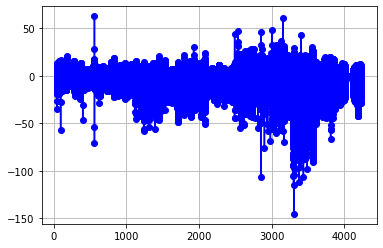

In [73]:
def cross(series, cross=0, direction='cross'):
    """
    Given a Series returns all the index values where the data values equal 
    the 'cross' value. 

    Direction can be 'rising' (for rising edge), 'falling' (for only falling 
    edge), or 'cross' for both edges
    """
    # Find if values are above or bellow yvalue crossing:
    above=series.values > cross
    below=np.logical_not(above)
    left_shifted_above = above[1:]
    left_shifted_below = below[1:]
    x_crossings = []
    # Find indexes on left side of crossing point
    if direction == 'rising':
        idxs = (left_shifted_above & below[0:-1]).nonzero()[0]
    elif direction == 'falling':
        idxs = (left_shifted_below & above[0:-1]).nonzero()[0]
    else:
        rising = left_shifted_above & below[0:-1]
        falling = left_shifted_below & above[0:-1]
        idxs = (rising | falling).nonzero()[0]

    # Calculate x crossings with interpolation using formula for a line:
    x1 = series.index.values[idxs]
    x2 = series.index.values[idxs+1]
    y1 = series.values[idxs]
    y2 = series.values[idxs+1]
    x_crossings = (cross-y1)*(x2-x1)/(y2-y1) + x1

    return x_crossings

# Test it out:
time = imputed_df['timestamp']
voltage = imputed_df['w2']
df = pd.DataFrame(data=voltage, index=time, columns=['voltage'])
x_crossings = cross(df['voltage'])
y_crossings = np.zeros(x_crossings.shape)
plt.plot(time, voltage, '-ob', x_crossings, y_crossings, 'or')
plt.grid(True)
